100%|██████████| 1000/1000 [00:35<00:00, 28.30it/s]


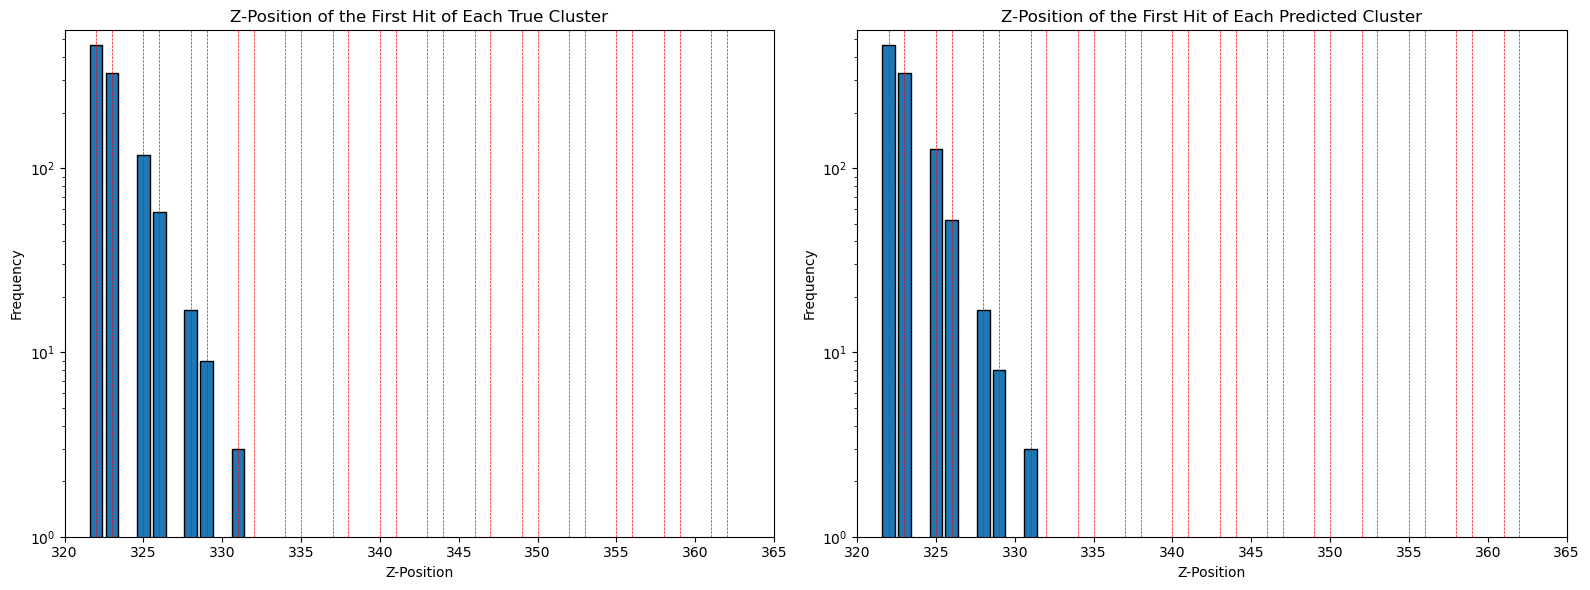

In [1]:
# First hit for every predicted and true cluster.

import pickle
import numpy as np
import torch
import glob
import matplotlib.pyplot as plt
from tqdm import tqdm

# Set file pattern and file limit
file_pattern = r'C:\Users\tsoli\OneDrive\Documents\School\1 - University of Minnesota\Year 17\Year 1 Research\picklefiles\photons\*.pkl'
file_limit = 1000

# Layer positions
layer_positions = [
    3.22e+02, 3.23e+02, 3.25e+02, 3.26e+02, 3.28e+02, 3.29e+02, 3.31e+02, 3.32e+02, 3.34e+02, 3.35e+02,
    3.37e+02, 3.38e+02, 3.40e+02, 3.41e+02, 3.43e+02, 3.44e+02, 3.46e+02, 3.47e+02, 3.49e+02, 3.50e+02,
    3.52e+02, 3.53e+02, 3.55e+02, 3.56e+02, 3.58e+02, 3.59e+02, 3.61e+02, 3.62e+02, 3.68e+02, 3.73e+02,
    3.79e+02, 3.84e+02, 3.89e+02, 3.95e+02, 4.00e+02, 4.06e+02, 4.11e+02, 4.17e+02, 4.22e+02, 4.28e+02,
    4.36e+02, 4.45e+02, 4.53e+02, 4.62e+02, 4.70e+02, 4.79e+02, 4.87e+02, 4.96e+02, 5.05e+02, 5.13e+02
]
layer_positions = np.array([int(pos) for pos in layer_positions])

# Load data from pkl files
def load_data(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
        score_noise_filter = pickle.load(f)
        pass_noise_filter = pickle.load(f)
        out_gravnet = pickle.load(f)
    return data, score_noise_filter, pass_noise_filter, out_gravnet

# Clustering algorithm from plots3D.
def get_clustering(beta, X, threshold_beta=0.2, threshold_dist=0.5):
    n_points = beta.shape[0]
    select_condpoints = beta > threshold_beta
    indices_condpoints = np.nonzero(select_condpoints)[0]
    indices_condpoints = indices_condpoints[np.argsort(-beta[select_condpoints])]
    unassigned = np.arange(n_points)
    clustering = -1 * np.ones(n_points, dtype=np.int32)
    
    for index_condpoint in indices_condpoints:
        d = np.linalg.norm(X[unassigned] - X[index_condpoint], axis=-1)
        assigned_to_this_condpoint = unassigned[d < threshold_dist]
        clustering[assigned_to_this_condpoint] = index_condpoint
        unassigned = unassigned[~(d < threshold_dist)]
    
    return clustering

# Parsing true input.
def process_data(data):
    true_energies = data.x[:, 0].numpy()
    true_clusters = data.y.numpy()
    zpos = data.x[:, 7].numpy()
    return true_energies, true_clusters, zpos

# Parsing network output.
def process_gravnet(score_noise_filter, pass_noise_filter, out_gravnet):
    beta = torch.sigmoid(out_gravnet[:, 0]).numpy()
    cluster_space_coords = out_gravnet[:, 1:].numpy()
    pred_clusters_pnf = get_clustering(beta, cluster_space_coords, threshold_beta=0.2, threshold_dist=0.5)
    pred_clusters = np.zeros_like(pass_noise_filter, dtype=np.int32)
    pred_clusters[pass_noise_filter] = pred_clusters_pnf
    
    # Count hits per cluster
    unique, counts = np.unique(pred_clusters, return_counts=True)
    cluster_counts = dict(zip(unique, counts))
    
    # Create final_pred_hits with clusters having less than 100 hits labeled as -2
    final_pred_hits = np.array([cluster if cluster_counts[cluster] >= 100 else -2 for cluster in pred_clusters])
    
    return final_pred_hits

def find_nearest_layer_position(z_value, layer_positions):
    return layer_positions[np.argmin(np.abs(layer_positions - z_value))]

def main():
    files = glob.glob(file_pattern)[:file_limit]

    first_hit_z_positions_pred = []
    first_hit_z_positions_true = []

    for file_path in tqdm(files):
        data, score_noise_filter, pass_noise_filter, out_gravnet = load_data(file_path)
        _, true_clusters, zpos = process_data(data)
        final_pred_hits = process_gravnet(score_noise_filter, pass_noise_filter, out_gravnet)
        
        # Identify the first hit for each predicted cluster
        unique_pred_clusters = np.unique(final_pred_hits)
        for cluster in unique_pred_clusters:
            if cluster == -1 or cluster == -2 or cluster == 0:
                continue  # Skip noise points and clusters with less than 100 hits
            cluster_indices = np.where(final_pred_hits == cluster)[0]
            first_hit_index = cluster_indices[np.argmin(zpos[cluster_indices])]
            nearest_layer_position = find_nearest_layer_position(zpos[first_hit_index], layer_positions)
            first_hit_z_positions_pred.append(nearest_layer_position)

        # Identify the first hit for each true cluster
        unique_true_clusters = np.unique(true_clusters)
        for cluster in unique_true_clusters:
            if cluster == -1 or cluster == 0:
                continue  # Skip noise points
            cluster_indices = np.where(true_clusters == cluster)[0]
            first_hit_index = cluster_indices[np.argmin(zpos[cluster_indices])]
            nearest_layer_position = find_nearest_layer_position(zpos[first_hit_index], layer_positions)
            first_hit_z_positions_true.append(nearest_layer_position)
    
    # Prepare data for plotting predicted clusters
    z_position_counts_pred, _ = np.histogram(first_hit_z_positions_pred, bins=np.append(layer_positions, layer_positions[-1] + 1))

    # Prepare data for plotting true clusters
    z_position_counts_true, _ = np.histogram(first_hit_z_positions_true, bins=np.append(layer_positions, layer_positions[-1] + 1))

    # Determine common x and y axis ranges
    x_min, x_max = layer_positions.min(), layer_positions.max()
    y_max = max(z_position_counts_pred.max(), z_position_counts_true.max())

    # Plot histogram of the z-position of the first hit of every true cluster
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.bar(layer_positions, z_position_counts_true, edgecolor='black')
    for pos in layer_positions:
        plt.axvline(x=pos, color='red', linestyle='--', linewidth=0.5)
    plt.xlabel('Z-Position')
    plt.ylabel('Frequency')
    plt.title('Z-Position of the First Hit of Each True Cluster')
    plt.xlim(320, 365)
    plt.ylim(1, 1.2 * y_max)
    plt.yscale('log')

    # Plot histogram of the z-position of the first hit of every predicted cluster
    plt.subplot(1, 2, 2)
    plt.bar(layer_positions, z_position_counts_pred, edgecolor='black')
    for pos in layer_positions:
        plt.axvline(x=pos, color='red', linestyle='--', linewidth=0.5)
    plt.xlabel('Z-Position')
    plt.ylabel('Frequency')
    plt.title('Z-Position of the First Hit of Each Predicted Cluster')
    plt.xlim(320, 365)
    plt.ylim(1, 1.2 * y_max)
    plt.yscale('log')

    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    main()

In [2]:
# Highest energy layer for every predicted and true cluster.

import pickle
import numpy as np
import torch
import glob
import matplotlib.pyplot as plt
from tqdm import tqdm

# Set file pattern and file limit
file_pattern = r'C:\Users\tsoli\OneDrive\Documents\School\1 - University of Minnesota\Year 17\Year 1 Research\picklefiles\photons\*.pkl'
file_limit = 1000

# Layer positions for binning
layer_positions = [
    3.22e+02, 3.23e+02, 3.25e+02, 3.26e+02, 3.28e+02, 3.29e+02, 3.31e+02, 3.32e+02, 3.34e+02, 3.35e+02,
    3.37e+02, 3.38e+02, 3.40e+02, 3.41e+02, 3.43e+02, 3.44e+02, 3.46e+02, 3.47e+02, 3.49e+02, 3.50e+02,
    3.52e+02, 3.53e+02, 3.55e+02, 3.56e+02, 3.58e+02, 3.59e+02, 3.61e+02, 3.62e+02, 3.68e+02, 3.73e+02,
    3.79e+02, 3.84e+02, 3.89e+02, 3.95e+02, 4.00e+02, 4.06e+02, 4.11e+02, 4.17e+02, 4.22e+02, 4.28e+02,
    4.36e+02, 4.45e+02, 4.53e+02, 4.62e+02, 4.70e+02, 4.79e+02, 4.87e+02, 4.96e+02, 5.05e+02, 5.13e+02
]
layer_positions = np.array([int(pos) for pos in layer_positions])

# Load data from pkl files
def load_data(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
        score_noise_filter = pickle.load(f)
        pass_noise_filter = pickle.load(f)
        out_gravnet = pickle.load(f)
    return data, score_noise_filter, pass_noise_filter, out_gravnet

# Clustering algorithm from plots3D.
def get_clustering(beta, X, threshold_beta=0.2, threshold_dist=0.5):
    n_points = beta.shape[0]
    select_condpoints = beta > threshold_beta
    indices_condpoints = np.nonzero(select_condpoints)[0]
    indices_condpoints = indices_condpoints[np.argsort(-beta[select_condpoints])]
    unassigned = np.arange(n_points)
    clustering = -1 * np.ones(n_points, dtype=np.int32)
    
    for index_condpoint in indices_condpoints:
        d = np.linalg.norm(X[unassigned] - X[index_condpoint], axis=-1)
        assigned_to_this_condpoint = unassigned[d < threshold_dist]
        clustering[assigned_to_this_condpoint] = index_condpoint
        unassigned = unassigned[~(d < threshold_dist)]
    
    return clustering

# Parsing true input.
def process_data(data):
    true_energies = data.x[:, 0].numpy()
    true_clusters = data.y.numpy()
    zpos = data.x[:, 7].numpy()
    return true_energies, true_clusters, zpos

# Parsing network output.
def process_gravnet(score_noise_filter, pass_noise_filter, out_gravnet):
    beta = torch.sigmoid(out_gravnet[:, 0]).numpy()
    cluster_space_coords = out_gravnet[:, 1:].numpy()
    pred_clusters_pnf = get_clustering(beta, cluster_space_coords, threshold_beta=0.2, threshold_dist=0.5)
    pred_clusters = np.zeros_like(pass_noise_filter, dtype=np.int32)
    pred_clusters[pass_noise_filter] = pred_clusters_pnf
    
    # Count hits per cluster
    unique, counts = np.unique(pred_clusters, return_counts=True)
    cluster_counts = dict(zip(unique, counts))
    
    # Create final_pred_hits with clusters having less than 100 hits labeled as -2
    final_pred_hits = np.array([cluster if cluster_counts[cluster] >= 100 else -2 for cluster in pred_clusters])
    
    return final_pred_hits

def find_nearest_layer(zpos, layer_positions):
    nearest_layers = np.array([layer_positions[np.argmin(np.abs(layer_positions - z))] for z in zpos])
    return nearest_layers

def main():
    files = glob.glob(file_pattern)[:file_limit]

    max_energy_z_positions_pred = []
    max_energy_z_positions_true = []
    nearest_layer_positions_pred = []
    nearest_layer_positions_true = []

    for file_path in tqdm(files):
        data, score_noise_filter, pass_noise_filter, out_gravnet = load_data(file_path)
        true_energies, true_clusters, zpos = process_data(data)
        final_pred_hits = process_gravnet(score_noise_filter, pass_noise_filter, out_gravnet)
        
        # Identify the z-position with the most energy for each predicted cluster
        unique_pred_clusters = np.unique(final_pred_hits)
        for cluster in unique_pred_clusters:
            if cluster == -1 or cluster == -2 or cluster == 0:
                continue  # Skip noise points and clusters with less than 100 hits
            cluster_indices = np.where(final_pred_hits == cluster)[0]
            cluster_energies = true_energies[cluster_indices]
            cluster_zpos = zpos[cluster_indices]
            
            # Sum energies for each z-position
            zpos_energy_sum = {}
            for z, energy in zip(cluster_zpos, cluster_energies):
                if z in zpos_energy_sum:
                    zpos_energy_sum[z] += energy
                else:
                    zpos_energy_sum[z] = energy
            
            # Find the z-position with the highest total energy
            max_energy_z = max(zpos_energy_sum, key=zpos_energy_sum.get)
            max_energy_z_positions_pred.append(max_energy_z)
            nearest_layer_positions_pred.append(find_nearest_layer([max_energy_z], layer_positions)[0])

        # Identify the z-position with the most energy for each true cluster
        unique_true_clusters = np.unique(true_clusters)
        for cluster in unique_true_clusters:
            if cluster == 0:
                continue  # Skip noise points
            cluster_indices = np.where(true_clusters == cluster)[0]
            cluster_energies = true_energies[cluster_indices]
            cluster_zpos = zpos[cluster_indices]
            
            # Sum energies for each z-position
            zpos_energy_sum = {}
            for z, energy in zip(cluster_zpos, cluster_energies):
                if z in zpos_energy_sum:
                    zpos_energy_sum[z] += energy
                else:
                    zpos_energy_sum[z] = energy
            
            # Find the z-position with the highest total energy
            max_energy_z = max(zpos_energy_sum, key=zpos_energy_sum.get)
            max_energy_z_positions_true.append(max_energy_z)
            nearest_layer_positions_true.append(find_nearest_layer([max_energy_z], layer_positions)[0])

    # Generate histograms with nearest layer positions
    nearest_layer_counts_pred, _ = np.histogram(nearest_layer_positions_pred, bins=layer_positions)
    nearest_layer_counts_true, _ = np.histogram(nearest_layer_positions_true, bins=layer_positions)
    
    # Plot histograms for comparison
    plt.figure(figsize=(18, 6))
    
    # Plot histogram with nearest layer positions for true clusters
    plt.subplot(1, 2, 1)
    plt.bar(layer_positions[:-1], nearest_layer_counts_true, edgecolor='black')
    for pos in layer_positions:
        plt.axvline(x=pos, color='red', linestyle='--', linewidth=0.5)
    plt.xlabel('Z-Position')
    plt.ylabel('Frequency')
    plt.title('Layer with the Most Energy for Each True Cluster')
    plt.xlim(315, 440)
    plt.ylim(1, 1.2 * max(nearest_layer_counts_true))
    plt.yscale('log')
    
    # Plot histogram with nearest layer positions for predicted clusters
    plt.subplot(1, 2, 2)
    plt.bar(layer_positions[:-1], nearest_layer_counts_pred, edgecolor='black')
    for pos in layer_positions:
        plt.axvline(x=pos, color='red', linestyle='--', linewidth=0.5)
    plt.xlabel('Z-Position')
    plt.ylabel('Frequency')
    plt.title('Layer with the Most Energy for Each Predicted Cluster')
    plt.xlim(315, 440)
    plt.ylim(1, 1.2 * max(nearest_layer_counts_pred))
    plt.yscale('log')
    
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    main()

ModuleNotFoundError: No module named 'torch'